In [1]:
#For the project Proposal

## Introduction

Tennis is a sport enjoyed by millions of people around the world. It involves two to four players competing against each other to hit a ball over a net with rackets. Professional tennis players compete in various tournaments throughout the year, accruing prize money based on their performance. Understanding the potential earnings of top players in the upcoming season is crucial for fans, sponsors and the players themselves.

The question our project aims to answer is: How much will a tennis player earn next season? To answer this question, we will use a dataset called "Player Statistics for Top 500 Players". This dataset contains comprehensive information on the top 500 tennis players, including their personal information, rankings, prize money earned in previous seasons and so on. It provides valuable data for analyzing historical trends and predicting future bonus earnings.

## Exploratory Data Analysis

In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
library(rvest)
library(stringr)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [8]:
tennis <- read_csv('player_stats.csv')
colnames(tennis) <- make.names(colnames(tennis))

tennis_data <- tennis |>
filter(Active == "Yes") |>
select(Age:Plays, Current.Rank:Prize.Money, Seasons, Current.Elo.Rank:Peak.Elo.Rating) |>
separate(col = Age, into = c("Age", "Birth.Date"), sep = " ") |>
separate(col = Current.Rank, into = c("Current.Rank", "Prev.Rank"), sep = " ") |>
separate(col = Best.Rank, into = c("Best.Rank", "Best.Rank.Date"), sep = " ") |>
separate(col = Current.Elo.Rank, into = c("Current.Elo.Rank", "Current.Elo.Rating"), sep = " ") |>
separate(col = Best.Elo.Rank, into = c("Best.Elo.Rank", "Best.Elo.Rank.Date"), sep = " ") |>
separate(col = Peak.Elo.Rating, into = c("Peak.Elo.Rating", "Peak.Elo.Rating.Date"), sep = " ") |>
mutate(Current.Rank = as.numeric(Current.Rank), Current.Elo.Rank = as.numeric(Current.Elo.Rank), Age = as.numeric(Age),
       Best.Elo.Rank = as.numeric(Best.Elo.Rank), Peak.Elo.Rating = as.numeric(Peak.Elo.Rating), Best.Rank = as.numeric(Best.Rank),
       Prize.Money = as.numeric(gsub("[^0-9.-]", "", Prize.Money)),
       Current.Elo.Rating = as.numeric(gsub("[^0-9.-]", "", Current.Elo.Rating)),
       Prev.Rank = as.numeric(gsub("[^0-9.-]", "", Prev.Rank)),
       Money.Per.Season = Prize.Money/Seasons) |>
select(Name, Age, Seasons, Current.Rank, Prev.Rank, Best.Rank, Current.Elo.Rank, Current.Elo.Rating, Best.Elo.Rank, Peak.Elo.Rating,
           Prize.Money, Money.Per.Season)
tennis_data

New names:
• `` -> `...1`
Rows: 500 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (25): Age, Country, Plays, Wikipedia, Current Rank, Best Rank, Name, Bac...
dbl (13): ...1, Turned Pro, Seasons, Titles, Best Season, Retired, Masters, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


Name,Age,Seasons,Current.Rank,Prev.Rank,Best.Rank,Current.Elo.Rank,Current.Elo.Rating,Best.Elo.Rank,Peak.Elo.Rating,Prize.Money,Money.Per.Season
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Lukas Lacko,32,14,178,280,44,144,1764,60,1886,3261567,232969.1
Duck Hee Lee,21,2,236,199,130,NA,NA,NA,NA,374093,187046.5
Bernard Tomic,27,11,183,273,17,100,1826,21,2037,6091971,553815.5
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Dimitar Kuzmanov,26,8,324,120,249,180,1679,179,1679,132871,16608.88
Artem Dubrivnyy,20,1,397,89,394,NA,NA,NA,NA,40724,40724.00
Dominic Thiem,26,10,5,5890,4,6,2188,5,2211,NA,NA


In [9]:
set.seed(16)
tennis_split <- initial_split(tennis_data, prop = 0.75, strata = Money.Per.Season)
tennis_training <- training(tennis_split)
tennis_testing <- testing(tennis_split)

Below is a table organizing the players by number of active seasons, and giving the mean values for potential predictor variables. Additionally, we included a table containing the amount of missing values for each predictor variable over our training set.

In [10]:
players_by_seasons <- tennis_training |>
    group_by(Seasons) |>
    summarize(count = n(), Mean.Age = mean(Age, na.rm = TRUE),
              Mean.Best.Rank = mean(Best.Rank,na.rm = TRUE), Mean.Peak.Rating = mean(Peak.Elo.Rating,na.rm = TRUE),
              Mean.Current.Rank = mean(Current.Rank, na.rm = TRUE), Mean.Current.Rating = mean(Current.Elo.Rating, na.rm = TRUE))
missing_tennis_data <- tennis_training |>
    summarize(Active.Players = n(),
              Missing.Age = sum(is.na(Age)),
              Missing.Best.Rank = sum(is.na(Best.Rank)),
              Missing.Current.Rank = sum(is.na(Current.Rank)),
              Missing.Peak.Elo = sum(is.na(Peak.Elo.Rating)),
              Missing.Current.Elo = sum(is.na(Current.Elo.Rating)))
players_by_seasons
missing_tennis_data

Seasons,count,Mean.Age,Mean.Best.Rank,Mean.Peak.Rating,Mean.Current.Rank,Mean.Current.Rating
<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,14,22.07143,312.7857,NaN,335.5714,NaN
2,21,22.42857,203.0952,1792.000,245.7619,1784.000
3,25,23.48000,142.6400,1839.273,187.7200,1812.364
⋮,⋮,⋮,⋮,⋮,⋮,⋮
20,2,39,25.5,2016,157.5,1846
21,1,37,5.0,2106,200.0,NaN
22,1,38,12.0,2074,57.0,1944


Active.Players,Missing.Age,Missing.Best.Rank,Missing.Current.Rank,Missing.Peak.Elo,Missing.Current.Elo
<int>,<int>,<int>,<int>,<int>,<int>
210,0,0,0,54,74


Below are some plots visualizing the relationships between potential predictor variables and Prize Money, or Prize Money per Season.
Due to being an extreme outlier in terms of Prize Money, for visualization purposes we have removed Rafael Nadal from the data set. We still plan to use him in our model.

$title
[1] "Seasons vs Prize Money"

attr(,"class")
[1] "labels"

$title
[1] "Seasons vs Money per Seasons"

attr(,"class")
[1] "labels"

$title
[1] "Age vs Money Per Season"

attr(,"class")
[1] "labels"

$title
[1] "Peak Elo Rating vs Prize Money"

attr(,"class")
[1] "labels"

$title
[1] "Best Rank vs Prize Money"

attr(,"class")
[1] "labels"

$title
[1] "Current Elo vs Money per Year"

attr(,"class")
[1] "labels"

$title
[1] "Current Rank vs Money per Year"

attr(,"class")
[1] "labels"

$title
[1] "Current Rank vs Current Elo Rating"

attr(,"class")
[1] "labels"

Warning message:
“Removed 20 rows containing missing values (geom_point).”
Warning message:
“Removed 20 rows containing missing values (geom_point).”


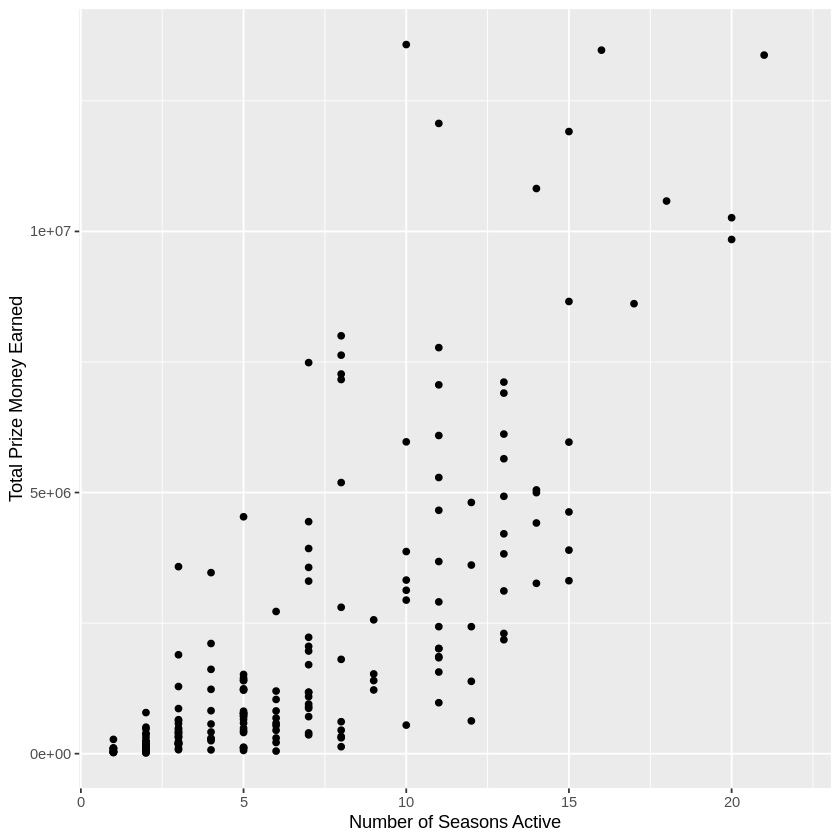

Warning message:
“Removed 20 rows containing missing values (geom_point).”


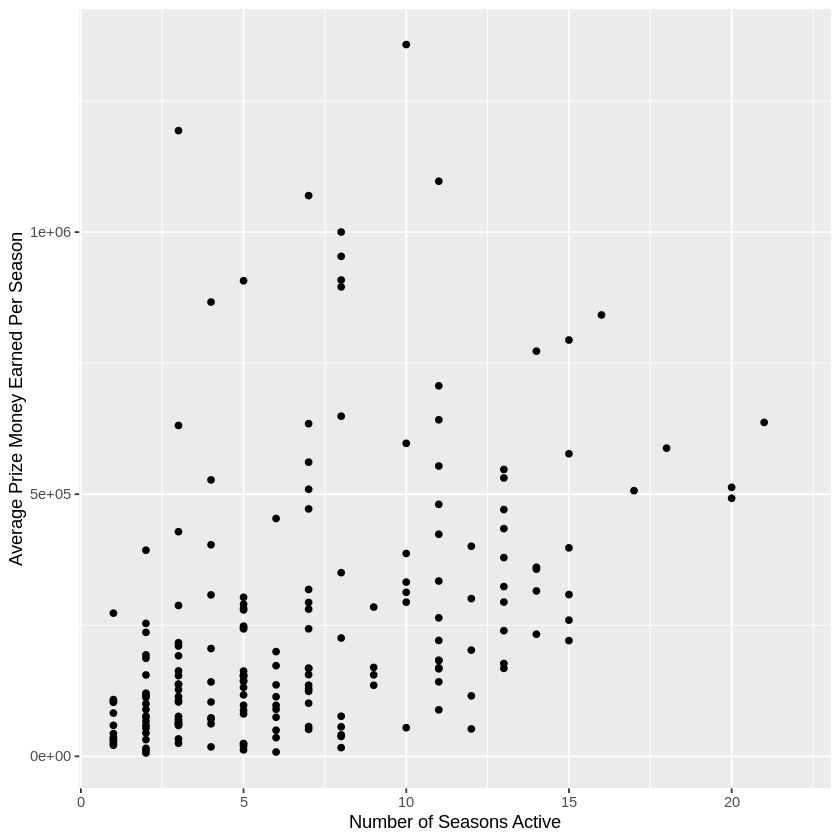

Warning message:
“Removed 71 rows containing missing values (geom_point).”


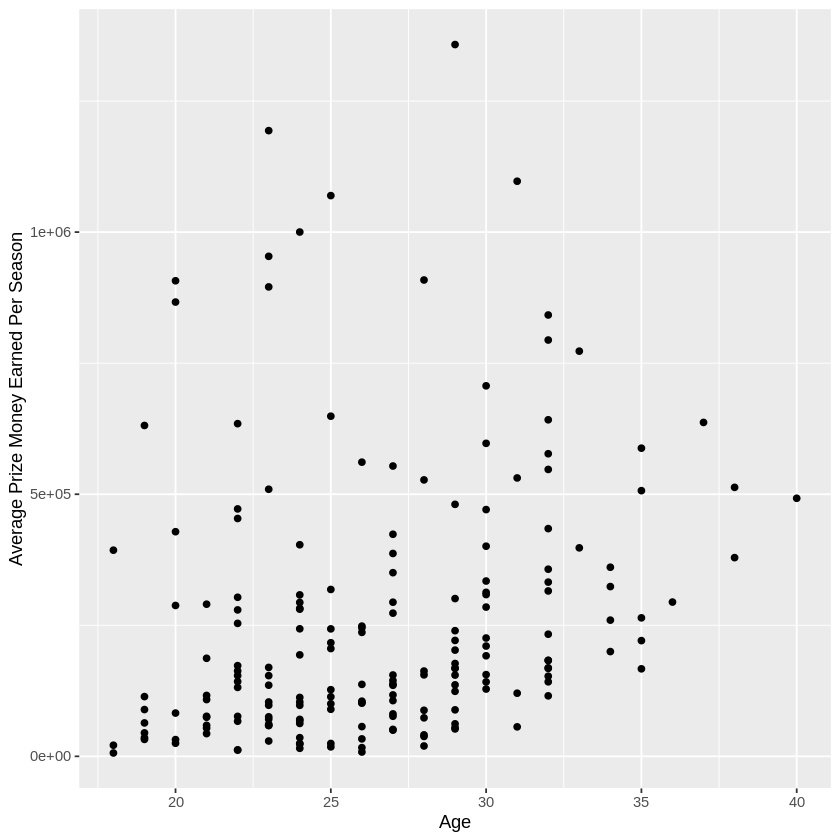

Warning message:
“Removed 20 rows containing missing values (geom_point).”


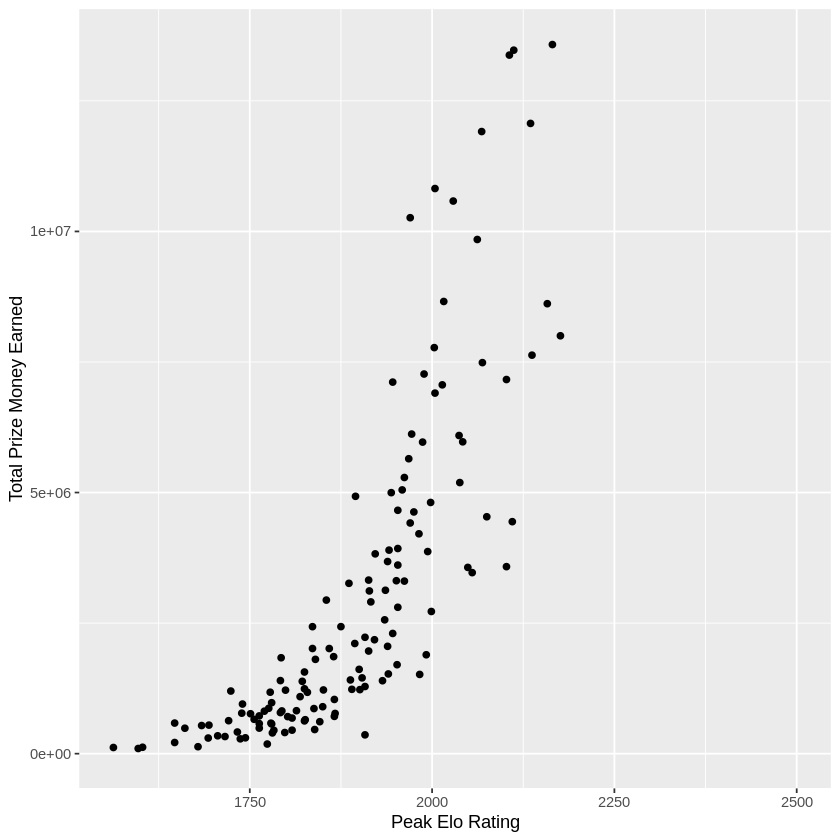

Warning message:
“Removed 89 rows containing missing values (geom_point).”


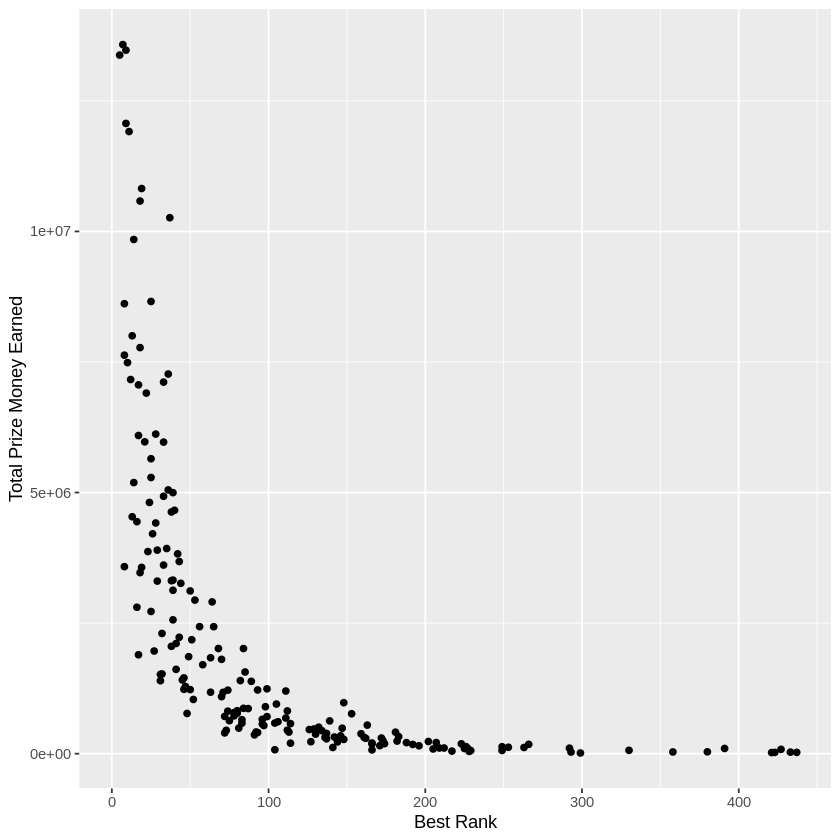

Warning message:
“Removed 20 rows containing missing values (geom_point).”


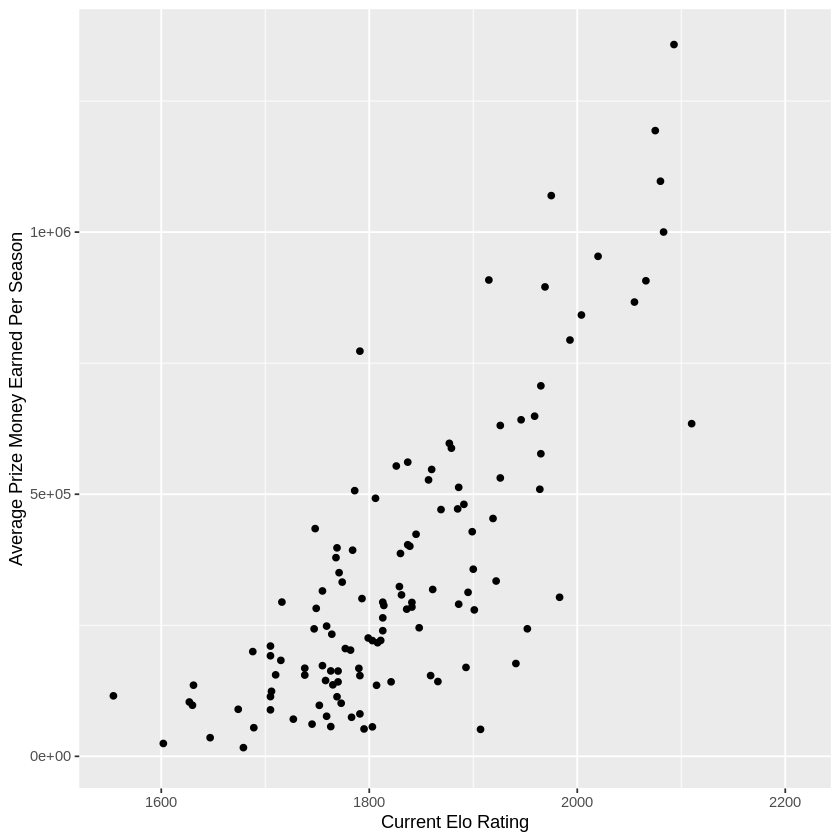

Warning message:
“Removed 74 rows containing missing values (geom_point).”


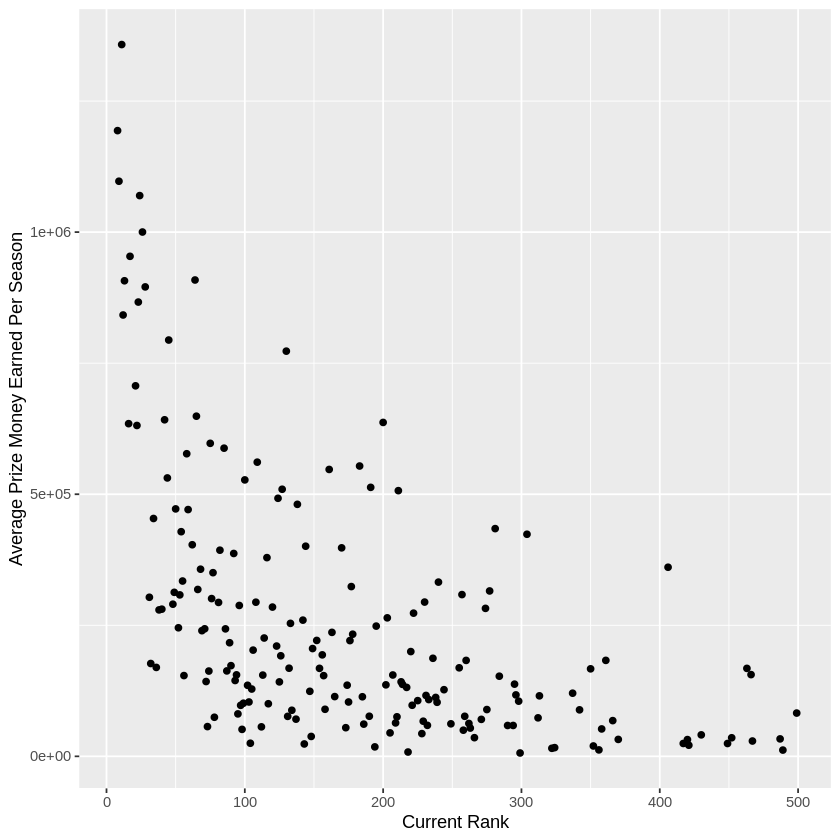

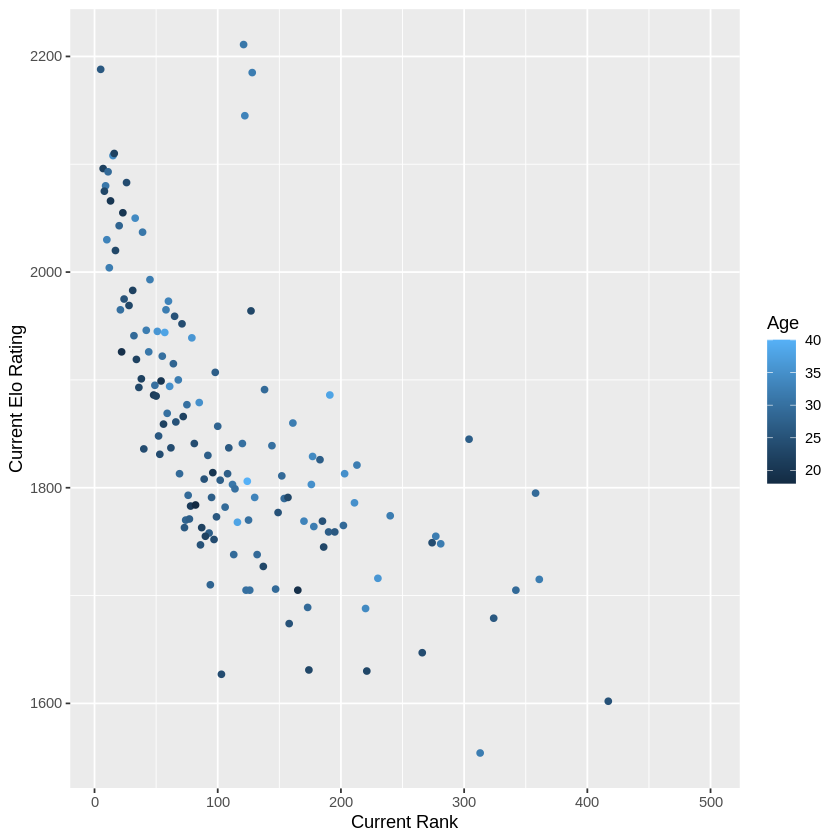

In [11]:
tennis_data_for_viz <- tennis_training |>
    filter(Name != "Rafael Nadal")

tennis_plot_seasons <- tennis_data_for_viz |>
    ggplot(aes(x = Seasons, y = Prize.Money)) +
    geom_point() +
    labs(x = "Number of Seasons Active", y = "Total Prize Money Earned")
    ggtitle("Seasons vs Prize Money")
tennis_plot_money_per_season <- tennis_data_for_viz |>
    ggplot(aes(x = Seasons, y = Money.Per.Season)) +
    geom_point() +
    labs(x = "Number of Seasons Active", y = "Average Prize Money Earned Per Season")
    ggtitle("Seasons vs Money per Seasons")
tennis_plot_age <- tennis_data_for_viz |>
    ggplot(aes(x = Age, y = Money.Per.Season)) +
    geom_point() +
    labs(x = "Age", y = "Average Prize Money Earned Per Season")
    ggtitle("Age vs Money Per Season")
tennis_plot_elo <- tennis_data_for_viz |>
    ggplot(aes(x = Peak.Elo.Rating, y = Prize.Money)) +
    geom_point() +
    labs(x = "Peak Elo Rating", y  = "Total Prize Money Earned")
    ggtitle("Peak Elo Rating vs Prize Money")
tennis_plot_rank <- tennis_data_for_viz |>
    ggplot(aes(x = Best.Rank, y = Prize.Money)) +
    geom_point() +
    labs(x = "Best Rank", y = "Total Prize Money Earned")
    ggtitle("Best Rank vs Prize Money")
tennis_plot_elo_perYear <- tennis_data_for_viz |>
    ggplot(aes(x = Current.Elo.Rating, y = Money.Per.Season)) +
    geom_point() +
    labs(x = "Current Elo Rating", y = "Average Prize Money Earned Per Season")
    ggtitle("Current Elo vs Money per Year")
tennis_plot_rank_perYear <- tennis_data_for_viz |>
    ggplot(aes(x = Current.Rank, y = Money.Per.Season)) +
    geom_point() +
    labs(x = "Current Rank", y = "Average Prize Money Earned Per Season")
    ggtitle("Current Rank vs Money per Year")
tennis_plot_current_rank_elo <- tennis_data_for_viz |>
    ggplot(aes(x = Current.Rank, y = Current.Elo.Rating, color = Age)) +
    geom_point() +
    labs(x = "Current Rank", y = "Current Elo Rating")
    ggtitle("Current Rank vs Current Elo Rating")
tennis_plot_seasons
tennis_plot_money_per_season
tennis_plot_age
tennis_plot_elo
tennis_plot_rank
tennis_plot_elo_perYear
tennis_plot_rank_perYear
tennis_plot_current_rank_elo

## Methods

We will use a k-nearest neighbors regression model to predict prize money a play will recieve next season based on their elo rating, current rank, and age. 

We will scale total prize money to money per season by dividing it by each player's respective number of seasons. Preliminary plots of possible predictors revelaed that elo rating and current rank have the strongest correlation with money per season. Age had a weaker coorelation but according to our reseach tennis player retire unusally young leading us to believe that their age has an impact on their play and the money they earn. Every player has a current rank, and age meaning a majority of the observations will be relevent for our model and even though thought 54 player in the training set were missing elo rating it correlated the strongest with money per year. Notably, elo rating displayed a non-linear relationship making a knn regression model the best option.

We will generate scatter plots of scaled prize money vs each predictor variable and overlay lines plots of predicted scaled prize money vs each predictor variable so that we can see how well our model performed relative to each predictor variable. We can also look to see if any overfitting or underfitting of the data occured. 

## Expected Outcomes and Signifigance

We expect to create a model capable of predicting the amount of money a player will win in the coming season based on their current rank, elo rating, and age. One impact this could have is it could allow players to predict their income for a season of playing as well as help competitions judge how much prize money they neeed to be offering competative players. Especially considering age it could allow players to judge their financial stability relying soley on prize money as they get older. One future question could be at what age do players need to consider retirement if their earnings will decrease in the coming years? 

Workes Cited:
https://racketsportsworld.com/tennis-players-retire-young/
https://racquetsportscenter.com/what-age-do-tennis-players-retire/